In [1]:
import os
import numpy as np
import cv2

def get_image_sizes(folder_path: str):
    sizes = {}

    for filename in os.listdir(folder_path):
        try:
            if filename.endswith(".jpg"):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                if img.shape not in sizes:
                    sizes[img.shape] = 1
                else:
                    sizes[img.shape] += 1
        except Exception as e:
            print(f"Error opening {filename}: {e}")

    return sizes

print(get_image_sizes("./brain_tumor_dataset/brain_tumor_segmentation/train/images"))
print(get_image_sizes("./brain_tumor_dataset/brain_tumor_segmentation/train/labels"))
print(get_image_sizes("./brain_tumor_dataset/brain_tumor_segmentation/valid/images"))
print(get_image_sizes("./brain_tumor_dataset/brain_tumor_segmentation/valid/labels"))
print(get_image_sizes("./brain_tumor_dataset/brain_tumor_segmentation/test/images"))
print(get_image_sizes("./brain_tumor_dataset/brain_tumor_segmentation/test/labels"))

{(640, 640, 3): 102}
{(369, 369, 3): 102}
{(640, 640, 3): 30}
{(369, 369, 3): 30}
{(640, 640, 3): 15}
{(369, 369, 3): 15}


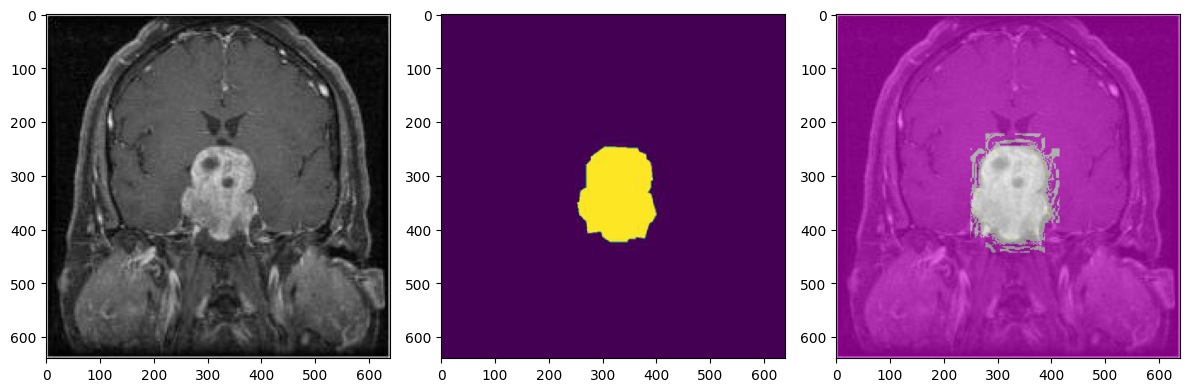

In [2]:
import os, random
from PIL import Image
import matplotlib.pyplot as plt

folder_path1 = "./brain_tumor_dataset/brain_tumor_segmentation/train/images"
folder_path2 = "./brain_tumor_dataset/brain_tumor_segmentation/train/labels"

filename = random.choice(os.listdir(folder_path1))
img_path1 = os.path.join(folder_path1, filename)
img_path2 = os.path.join(folder_path2, filename)

img1 = Image.open(img_path1).convert("RGB")
img2 = Image.open(img_path2)
img2 = img2.resize(img1.size, Image.NEAREST)

mask = np.array(img2)

# unique_colors, frequencies = np.unique(mask.reshape(-1, mask.shape[-1]), axis=0, return_counts=True)
# print("Unique colors and their frequencies in the mask:")
# for color, freq in zip(unique_colors, frequencies):
#     print(f"Color: {color}, Frequency: {freq}")

colored_mask = np.zeros(mask.shape)
colored_mask[mask > 0] = [1]

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

axes[0].imshow(img1)

axes[1].imshow(img2)

axes[2].imshow(img1, alpha=1.0)
axes[2].imshow(colored_mask, alpha=0.5)

plt.tight_layout()
plt.show()

In [3]:
from torch.utils.data import Dataset
import torch
import cv2

class TumorDataset(Dataset):
    def __init__(self, img_dir: str, mask_dir: str, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_paths = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_file = self.image_paths[idx]
        base_name = os.path.splitext(os.path.basename(img_file))[0]
        img_file = os.path.join(self.img_dir, img_file)
        mask_file = os.path.join(self.mask_dir, base_name + '.jpg')

        # print(f"Image file: {img_file}")
        # print(f"Mask file: {mask_file}")
        # print(f"Does Image file exist? {os.path.exists(img_file)}")
        # print(f"Does mask file exist? {os.path.exists(mask_file)}")

        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (640, 640), interpolation=cv2.INTER_AREA)

        new_mask = np.zeros(mask.shape)
        new_mask[mask == 215] = [1]

        if self.transform:
            augmented = self.transform(image=img, mask=new_mask)
            img, new_mask = augmented['image'], augmented['mask']

        img = img / 255.0    

        img_tensor = torch.from_numpy(img.transpose(2,0,1)).float()  # C,H,W
        mask_tensor = torch.from_numpy(new_mask).long() # H,W

        return img_tensor, mask_tensor

In [4]:
import albumentations as A

train_transforms = A.Compose([
    # A.RandomRotate90(p=0.5),
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    # A.RandomBrightnessContrast(p=0.3),
    # A.GaussNoise(p=0.2),
    # A.ElasticTransform(p=0.2),
    # A.CoarseDropout(max_holes=8, max_height=0.1, max_width=0.1, p=0.3),
    # A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    # A.RandomGamma(gamma_limit=(80, 120), p=0.2),
    # A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.2),
    A.Normalize()
])

val_transforms = A.Compose([
    A.Normalize()
])

train_transforms = None
val_transforms = None

In [5]:
from torch.utils.data import DataLoader

batch_size = 16

train_dataset = TumorDataset("./brain_tumor_dataset/brain_tumor_segmentation/train/images", "./brain_tumor_dataset/brain_tumor_segmentation/train/labels", transform=train_transforms)
val_dataset = TumorDataset("./brain_tumor_dataset/brain_tumor_segmentation/valid/images", "./brain_tumor_dataset/brain_tumor_segmentation/valid/labels", transform=val_transforms)
test_dataset = TumorDataset("./brain_tumor_dataset/brain_tumor_segmentation/test/images", "./brain_tumor_dataset/brain_tumor_segmentation/test/labels", transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
import torch
import torchvision
from segmentation_models_pytorch import Unet

def get_model():
    model = Unet(encoder_name='resnet34', in_channels=3, classes=2).cuda()
    return model

In [7]:
import torch
import numpy as np

PATH = './models/model17.pth'
model = get_model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

num_epochs = 25
min_val_loss = np.inf
min_val_loss_epoch = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for imgs, masks in train_loader:
        imgs = imgs.cuda()
        masks = masks.cuda()
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.cuda()
            masks = masks.cuda()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        min_val_loss_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

print(f"Epoch {min_val_loss_epoch}, Minimum Validation Loss: {min_val_loss}")

Epoch 1/25, Train Loss: 1.4801711354936873, Validation Loss: 2.453018307685852
Epoch 2/25, Train Loss: 1.0608230914388384, Validation Loss: 1.1506169438362122
Epoch 3/25, Train Loss: 0.8632101246288845, Validation Loss: 0.8492837250232697
Epoch 4/25, Train Loss: 0.7537079964365277, Validation Loss: 0.7915661334991455
Epoch 5/25, Train Loss: 0.698297279221671, Validation Loss: 0.7557907700538635
Epoch 6/25, Train Loss: 0.6534795675958905, Validation Loss: 0.7016331553459167
Epoch 7/25, Train Loss: 0.6275707312992641, Validation Loss: 0.6617379188537598
Epoch 8/25, Train Loss: 0.5957479476928711, Validation Loss: 0.6181585490703583
Epoch 9/25, Train Loss: 0.57779461145401, Validation Loss: 0.6031327247619629
Epoch 10/25, Train Loss: 0.5577079227992466, Validation Loss: 0.6462591588497162
Epoch 11/25, Train Loss: 0.5383122393063137, Validation Loss: 0.5523295104503632
Epoch 12/25, Train Loss: 0.5146411827632359, Validation Loss: 0.5120129883289337
Epoch 13/25, Train Loss: 0.49509713479450

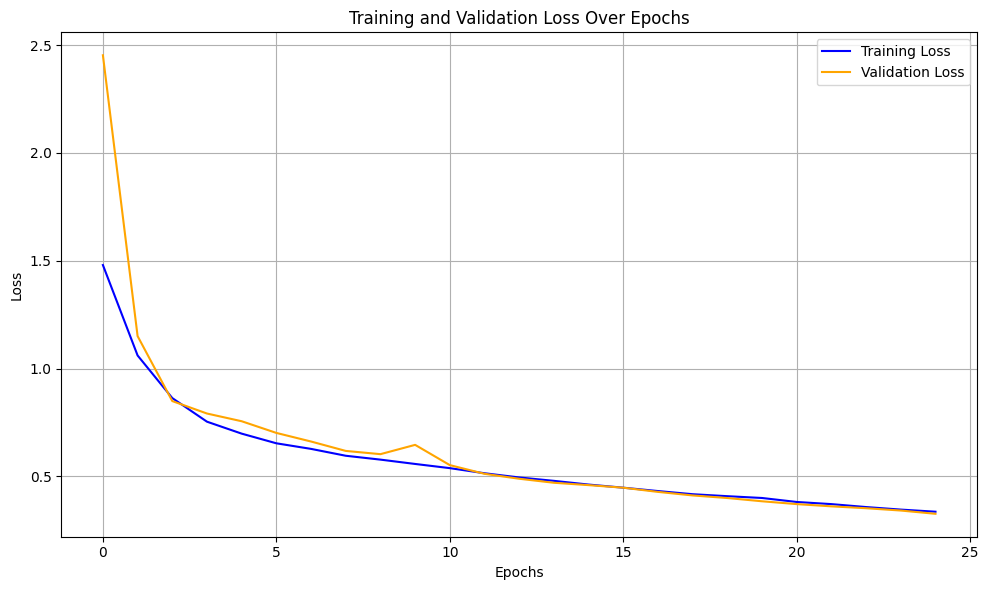

In [8]:
# Plot train and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [9]:
model = get_model()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
checkpoint = torch.load(PATH, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [10]:
import torch
import numpy as np

def dice_coefficient(preds, labels):
    intersection = np.sum(preds * labels)
    union = np.sum(preds) + np.sum(labels)
    return (2. * intersection) / (union + 1e-7)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for img, label in test_loader:
        img = img.cuda()
        label = label.cuda()

        outputs = model(img)
        _, preds = torch.max(outputs, 1)  # Convert outputs to binary predictions (segmentation)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Calculate Dice coefficient
dice_score = dice_coefficient(np.array(all_preds), np.array(all_labels))
print(f"Overall Dice Coefficient: {dice_score:.4f}")


Overall Dice Coefficient: 0.7535


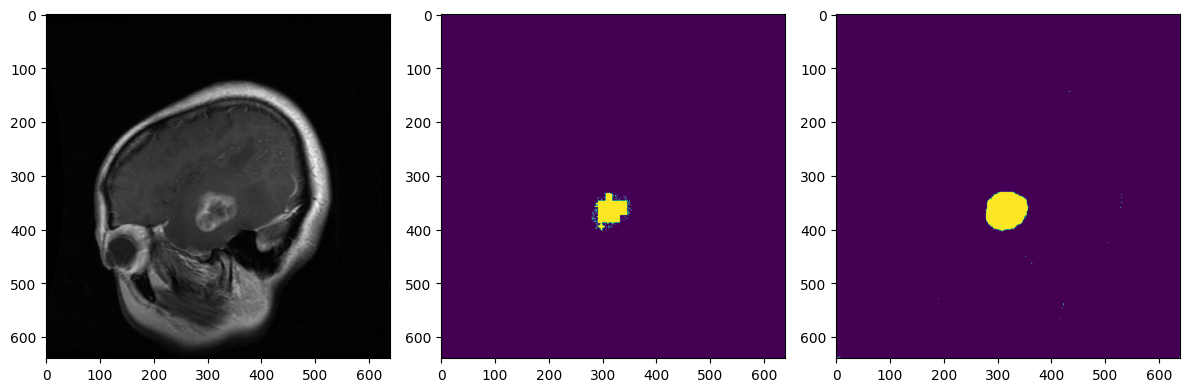

In [11]:
import torch
import numpy as np

with torch.no_grad():
    for img, label in test_loader:
        img = img.cuda()
        label = label.cuda()

        outputs = model(img)
        _, preds = torch.max(outputs, 1)  # Convert outputs to binary predictions (segmentation)

        label = label[0, :, :].cpu().numpy()
        preds = preds[0, :, :].cpu().numpy()
        img = img[0, :, :].cpu().numpy().transpose(1, 2, 0)

        fig, axes = plt.subplots(1, 3, figsize=(12, 6))

        axes[0].imshow(img)

        axes[1].imshow(label)

        axes[2].imshow(preds)

        plt.tight_layout()
        plt.show()

        break
